
**Lab 2 : Graph Property**
- Instuctor : Kijung Shin
- Teaching Assistants : Deukryeol Yoon(main), Hyunju Lee, Shinhwan Kang 
- 본 실습에서는 그래프의 다양한 특성 중 그래프 지름, 전역 군집 계수, 차수 분포를 배우고, 수업에서 배운 small world graph의 그래프 특성을 알아본다.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Lab 2 : Graph Property
# - Instuctor : Kijung Shin
# - Teaching Assistants : Deukryeol Yoon(main), Hyunju Lee, Shinhwan Kang 
# 본 실습에서는 그래프의 다양한 특성 중 Diameter, Average Clustering Coefficient, Degree Distribution을 배우고. 
# 수업에서 배운 small world graph의 그래프 특성을 알아본다.

# 실습에 필요한 library를 import하고 그래프를 초기화합니다.
import networkx as nx
import os
import os.path as osp
import numpy as np
import sys
import matplotlib.pyplot as plt
import collections
np.set_printoptions(threshold=sys.maxsize)

# 방향성 없는 그래프
cycle_graph = nx.Graph()
regular_graph = nx.Graph()
small_world_graph = nx.Graph()
random_graph = nx.Graph()

In [3]:
# 실습에 사용할 데이터를 읽어옵니다.
print("###### Read Graphs ######")
data = osp.abspath(osp.join(os.getcwd(), 'drive/MyDrive/data/lab/lab2/cycle.txt'))
f = open(data)
for line in f:
    v1, v2 = map(int, line.split())
    cycle_graph.add_edge(v1, v2)

# 균일 그래프
# 간선 리스트 형태 - 파일의 각 줄은 하나의 간선 의미
# 파일의 각 줄은 두 개의 정수로 구성
# 두 개의 정수가 간선에 의해 연결되는 두 개의 정점을 의미한다
data = osp.abspath(osp.join(os.getcwd(), 'drive/MyDrive/data/lab/lab2/regular.txt'))
f = open(data)
for line in f:
    v1, v2 = map(int, line.split())
    regular_graph.add_edge(v1, v2)  # 간선을 그래프 객체에 추가

# 작은 세상 그래프
data = osp.abspath(osp.join(os.getcwd(), 'drive/MyDrive/data/lab/lab2/small_world.txt'))
f = open(data)
for line in f:
    v1, v2, = map(int, line.split())
    small_world_graph.add_edge(v1, v2)

# random graph
data = osp.abspath(osp.join(os.getcwd(), 'drive/MyDrive/data/lab/lab2/random.txt'))
f = open(data)
for line in f:
    v1, v2 = map(int, line.split())
    random_graph.add_edge(v1, v2)

###### Read Graphs ######


In [4]:
# 그래프의 전역 군집 계수를 찾는 함수입니다.
#
# 특정 정점 u의 정점 계수(cc)는 아래와 같이 구할 수 있습니다.
# cc(u) = 2T(u)/(deg(u) * (deg(u) - 1))
#   - cc(u) : 정점 u의 군집계수
#   - T(u)  : 정점 u가 들어있는 삼각형 개수
#   - deg(u): 정점 u의 차수 (degree)
#
# 그리고 전역 군집 계수는 모든 node의 cc(u)의 평균을 의미합니다.
# 전역 군집 계수
# avg_cc(G) = sigma(u in G) cc(u) / n
#   - avg_cc(G) : 그래프 G의 전역 군집 계수
#   - n         : 그래프 G의 정점 개수

# 전역 군집 계수는 지역 군집 계수의 평균으로 계산
# 각 정점 v에 대해 지역 군집 계수 먼저 계산해야 한다
# ccs에 지역 군집 계수 추가해준다

def getGraphAverageClusteringCoefficient(Graph):
    ccs = []
    # v의 지역 군집 계수 계산
    for v in Graph.nodes:
        num_connected_pairs = 0
        # Graph.neighbors(v) - v 정점의 이웃들의 목록
        for neighbor1 in Graph.neighbors(v):
            for neighbor2 in Graph.neighbors(v):
                # 같은 정점 쌍 여러번 고려하지 않기 위해
                # (1, 2)와 (2, 1)은 같은 경우이므로
                if neighbor1 <= neighbor2:
                    continue
                # has_edge - 간선이 존재하는지 여부
                if Graph.has_edge(neighbor1, neighbor2):
                    num_connected_pairs = num_connected_pairs + 1
        # cc : 지역적 군집계수
        # num_connected_pairs : 이웃 쌍 중에서 실제로 간선으로 직접 연결된 것의 수
        # (Graph.degree(v) * (Graph.degree(v) - 1) / 2 : 이웃들의 쌍의 수
        # 정점 v는 연결성 dv만큼 가진다
        # 이웃들의 쌍의 수는 dvC2 = (Graph.degree(v) * (Graph.degree(v) - 1) / 2
        cc = num_connected_pairs / (Graph.degree(v) * (Graph.degree(v) - 1) / 2)
        ccs.append(cc)
    return sum(ccs) / len(ccs)

In [5]:
# 본 실습에서는 그래프의 다양한 특성 중 그래프 지름과 전역 군집 계수를 분석해봅니다.
# 그래프에서 Diameter, Average Clustering Coefficient를 찾는 알고리즘을 구현하고, networkx에서 제공하는 라이브러리와 결과를 비교해봅시다.

# 그래프의 지름을 찾는 함수입니다.
# Definition. Graph Diameter
#   The graph diameter of a graph is the length max(u,v)d(u,v) of the "longest shortest path between any two graph vertices (u,v), where d(u,v) is a graph distance.

# 지름 - 거리가 가장 먼 정점 상의 거리
# 모든 정점 쌍의 거리 계산해서, 가장 긴 것 찾는다
def getGraphDiameter(Graph):
    diameter = 0                                                      # 알고리즘을 시작하기 앞서 diameter 값을 0으로 초기화합니다.
    # 모든 정점에 대해 반복
    for v in Graph.nodes:                                             # 그래프의 모든 점점들 대해서 아래와 같은 반복문을 수행합니다.
        # 출발점(v)과 다른 정점들 사이 거리 저장
        length = nx.single_source_shortest_path_length(Graph, v)      #   1. 정점 v로 부터 다른 모든 정점으로 shortest path length를 찾습니다. 
        # v와 가장 거리가 먼 정점 사이 거리 반환
        max_length = max(length.values())                             #   2. 그리고 shortest path length 중 최댓값을 구합니다.
        if max_length > diameter:                                     #   3. 2에서 구한 값이 diameter보다 크다면 diameter를 그 값으로 업데이트 합니다.
            diameter = max_length
    return diameter                                                   # 반복문을 돌고 나온 diameter를 return합니다.

In [6]:
# 아래는 위의 함수로 구한 그래프 지름 및 전역 군집 계수 값과 networkX에서 지원하는 library로 구한 값을 비교해봅니다.
#
#                   |     그래프 지름        |     전역 군집 계수
# ------------------+------------------------------------------------------------                    
# Regular Graph     |         High           |              High
# Small World Graph |         Low            |              High
# Random Graph      |         Low            |              Low
#
print("1. Graph Diameter")
print("cycle graph : " + str(nx.diameter(cycle_graph)))
print("cycle graph : " + str(getGraphDiameter(cycle_graph)))

print("regular graph : " + str(nx.diameter(regular_graph)))
print("regular graph : " + str(getGraphDiameter(regular_graph)))

print("small world graph : " + str(nx.diameter(small_world_graph)))
print("small world graph : " + str(getGraphDiameter(small_world_graph)))

print("random graph : " + str(nx.diameter(random_graph)))
print("random graph : " + str(getGraphDiameter(random_graph)) + "\n")

print("2. Average Clustering Coefficient")
print("cycle graph : " + str(nx.average_clustering(cycle_graph)))
print("cycle graph : " + str(getGraphAverageClusteringCoefficient(cycle_graph)))
print("regular graph : " + str(nx.average_clustering(regular_graph)))
print("regular graph : " + str(getGraphAverageClusteringCoefficient(regular_graph)))

print("small world graph : " + str(nx.average_clustering(small_world_graph)))
print("small world graph : " + str(getGraphAverageClusteringCoefficient(small_world_graph)))


print("random graph : " + str(nx.average_clustering(random_graph)))
print("random graph : " + str(getGraphAverageClusteringCoefficient(random_graph)) + "\n")

1. Graph Diameter
cycle graph : 15
cycle graph : 15
regular graph : 8
regular graph : 8
small world graph : 6
small world graph : 6
random graph : 5
random graph : 5

2. Average Clustering Coefficient
cycle graph : 0.0
cycle graph : 0.0
regular graph : 0.5
regular graph : 0.5
small world graph : 0.42555555555555563
small world graph : 0.42555555555555563
random graph : 0.027777777777777776
random graph : 0.027777777777777776



3. Degree Distribution


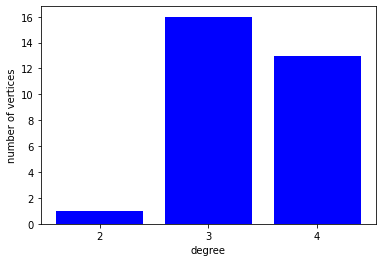

In [7]:
# 그래프의 차수 분포을 그리는 부분입니다.
print("3. Degree Distribution")
degree_sequence = sorted([d for n, d in random_graph.degree()], reverse = True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
plt.bar(deg, cnt, color="b")
plt.xlabel('degree')
plt.ylabel('number of vertices')
plt.xticks([2, 3, 4])
plt.show()
